In [2]:
import wget

In [6]:
wget.download(url = "https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py")

'helper_functions.py'

In [7]:
# Import helper functions we're going to use in this notebook
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, walk_through_dir

### Let's get some data

This time we're going to see how we can use the pretrained models within tf.keras.applications

link: `https://www.tensorflow.org.api_docs/python/tf/keras/applications`

In [8]:
# Check out how many images and subdirectories are in our dataset
walk_through_dir("10_food_classes_10_percent")

There are 1 directories and 0 images in '10_food_classes_10_percent'.
There are 8 directories and 0 images in '10_food_classes_10_percent\test'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\fried_rice'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\hamburger'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\ice_cream'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\pizza'.
There are 0 directories and 98 images in '10_food_classes_10_percent\test\ramen'.


In [9]:
# Create training and test directory paths
train_dir = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

In [10]:
import tensorflow as tf
IMG_SIZE = (224 , 224)
BATCH_SIZE = 32

train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(directory = train_dir,
                                                                            image_size = IMG_SIZE,
                                                                            label_mode = "categorical",
                                                                            batch_size = BATCH_SIZE)
test_data = tf.keras.preprocessing.image_dataset_from_directory(directory = test_dir,
                                                                image_size = IMG_SIZE,
                                                                label_mode = "categorical",
                                                                batch_size = BATCH_SIZE)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [11]:
train_data_10_percent

<BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>

In [12]:
train_data_10_percent.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

In [13]:
# See an example of a batch of data

for images, labels in train_data_10_percent.take(1):
    print(images , labels)

tf.Tensor(
[[[[3.00000000e+00 5.00000000e+00 2.00000000e+00]
   [2.00000000e+00 4.00000000e+00 1.00000000e+00]
   [1.21428585e+00 3.21428585e+00 2.14285851e-01]
   ...
   [7.85705566e-01 5.70917177e+00 1.70917189e+00]
   [0.00000000e+00 4.04590702e+00 4.59071621e-02]
   [4.13262546e-01 5.28570986e+00 1.28570998e+00]]

  [[2.04591823e+00 4.04591799e+00 1.04591823e+00]
   [2.00000000e+00 4.00000000e+00 1.00000000e+00]
   [1.21428585e+00 3.21428585e+00 2.14285851e-01]
   ...
   [9.84693289e-01 5.98469353e+00 1.98469329e+00]
   [9.28571701e-01 5.92857170e+00 1.92857170e+00]
   [3.16835928e+00 8.16835976e+00 4.16835928e+00]]

  [[1.78571415e+00 3.78571415e+00 1.21428585e+00]
   [1.78571415e+00 3.78571415e+00 7.85714149e-01]
   [1.95408154e+00 3.95408154e+00 9.54081595e-01]
   ...
   [2.59693718e+00 6.95407963e+00 3.07652497e+00]
   [2.62755513e+00 6.98469782e+00 2.77041173e+00]
   [5.07142448e+00 9.42856693e+00 5.21428108e+00]]

  ...

  [[4.45153465e+01 3.60868187e+01 2.53010845e+01]
   [4

> Functional API is more flexible and able to produce more sophisticated models

### Model 0: Building a transfer learning feature extraction model using the Keras Functional API

The sequential API is straight-forward, it runs out layers in sequential order.

But the functional API gives us more flexibility with our models - https://www.tensorflow.org/guide/keras/functional

In [16]:
# 1. Create base model with tf.keras.applications
base_model = tf.keras.applications.EfficientNetB0(include_top=False)

# 2. Freeze the base model (so the pre-learned patterns remain)
base_model.trainable = False

# 3. Create inputs into the base model
inputs = tf.keras.layers.Input(shape=(224, 224, 3), name="input_layer")

# 4. If using ResNet50V2, add this to speed up convergence, remove for EfficientNet
# x = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(inputs)

# 5. Pass the inputs to the base_model (note: using tf.keras.applications, EfficientNet inputs don't have to be normalized)
x = base_model(inputs)
# Check data shape after passing it to base_model
print(f"Shape after base_model: {x.shape}")

# 6. Average pool the outputs of the base model (aggregate all the most important information, reduce number of computations)
x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
print(f"After GlobalAveragePooling2D(): {x.shape}")

# 7. Create the output activation layer
outputs = tf.keras.layers.Dense(10, activation="softmax", name="output_layer")(x)

# 8. Combine the inputs with the outputs into a model
model_0 = tf.keras.Model(inputs, outputs)

# 9. Compile the model
model_0.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

# 10. Fit the model (we use less steps for validation so it's faster)
history_10_percent = model_0.fit(train_data_10_percent,
                                 epochs=5,
                                 steps_per_epoch=len(train_data_10_percent),
                                 validation_data= test_data,
                                 # Go through less of the validation data so epochs are faster (we want faster experiments!)
                                 validation_steps=int(0.25 * len(test_data)), 
                                 # Track our model's training logs for visualization later
                                 callbacks=[create_tensorboard_callback("transfer_learning", "10_percent_feature_extract")])

Shape after base_model: (None, 7, 7, 1280)
After GlobalAveragePooling2D(): (None, 1280)
Saving TensorBoard log files to: transfer_learning/10_percent_feature_extract/20220708-123153
Epoch 1/5
24/24 [==============================] - 172s 5s/step - loss: 1.9176 - accuracy: 0.4067 - val_loss: 1.3639 - val_accuracy: 0.7270
Epoch 2/5
24/24 [==============================] - 104s 4s/step - loss: 1.1609 - accuracy: 0.7413 - val_loss: 0.9338 - val_accuracy: 0.7993
Epoch 3/5
24/24 [==============================] - 139s 6s/step - loss: 0.8475 - accuracy: 0.8160 - val_loss: 0.7959 - val_accuracy: 0.7977
Epoch 4/5
24/24 [==============================] - 79s 3s/step - loss: 0.6923 - accuracy: 0.8440 - val_loss: 0.7019 - val_accuracy: 0.8125
Epoch 5/5
24/24 [==============================] - 84s 4s/step - loss: 0.5910 - accuracy: 0.8653 - val_loss: 0.6139 - val_accuracy: 0.8289


In [17]:
# Check the layers in our base model
for layer_number , layer in enumerate(base_model.layers):
    print(layer_number , layer.name)

0 input_3
1 rescaling_2
2 normalization_2
3 stem_conv_pad
4 stem_conv
5 stem_bn
6 stem_activation
7 block1a_dwconv
8 block1a_bn
9 block1a_activation
10 block1a_se_squeeze
11 block1a_se_reshape
12 block1a_se_reduce
13 block1a_se_expand
14 block1a_se_excite
15 block1a_project_conv
16 block1a_project_bn
17 block2a_expand_conv
18 block2a_expand_bn
19 block2a_expand_activation
20 block2a_dwconv_pad
21 block2a_dwconv
22 block2a_bn
23 block2a_activation
24 block2a_se_squeeze
25 block2a_se_reshape
26 block2a_se_reduce
27 block2a_se_expand
28 block2a_se_excite
29 block2a_project_conv
30 block2a_project_bn
31 block2b_expand_conv
32 block2b_expand_bn
33 block2b_expand_activation
34 block2b_dwconv
35 block2b_bn
36 block2b_activation
37 block2b_se_squeeze
38 block2b_se_reshape
39 block2b_se_reduce
40 block2b_se_expand
41 block2b_se_excite
42 block2b_project_conv
43 block2b_project_bn
44 block2b_drop
45 block2b_add
46 block3a_expand_conv
47 block3a_expand_bn
48 block3a_expand_activation
49 block3a_d

In [18]:
# How about we get a summary of the base model?
base_model.summary()

Model: "efficientnetb0"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 rescaling_2 (Rescaling)        (None, None, None,   0           ['input_3[0][0]']                
                                3)                                                                
                                                                                                  
 normalization_2 (Normalization  (None, None, None,   7          ['rescaling_2[0][0]']            
 )                              3)                                                   

In [19]:
# How about summary of our whole model?
model_0.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-trainable params: 4,049,571
_________________________________________________________________


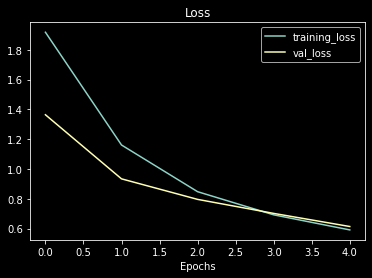

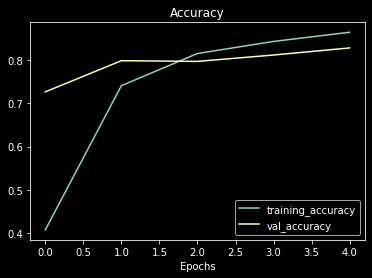

In [20]:
# Check out our model's training curves
plot_loss_curves(history_10_percent)

### Getting a feature vector from a trained model

Let's demonstrate the Global Average Pooling 2D layer...
We have a tensor after our model goes through `base_model` of shape (None, 7, 7, 1280)...

But then when it passed through GlobalAveragePooling2D, it turns into (None, 1280) 

Let's use a similar shaped tensorof (1, 4, 4, 3) and then pass it to GlobalAveragePooling2D.

In [23]:
# Define the input shape
input_shape = (1, 4, 4, 3)

# Create a random tensor
tf.random.set_seed(42)
input_tensor = tf.random.normal(input_shape)
print(f'Random input tensor:\n {input_tensor}\n')

# Pass the random tensor through global average pooling 2D layer
global_average_pooled_tensor = tf.keras.layers.GlobalAveragePooling2D()(input_tensor)
print(f'2D global average pooled random tensor:\n {global_average_pooled_tensor}\n')

# Check the shape of the different tensors
print(f"Shape of input tensor: {input_tensor.shape}")
print(f'Shape of Global Average Pooled 2D tensor: {global_average_pooled_tensor.shape}')

Random input tensor:
 [[[[ 0.3274685  -0.8426258   0.3194337 ]
   [-1.4075519  -2.3880599  -1.0392479 ]
   [-0.5573232   0.539707    1.6994323 ]
   [ 0.28893656 -1.5066116  -0.26454744]]

  [[-0.59722406 -1.9171132  -0.62044144]
   [ 0.8504023  -0.40604794 -3.0258412 ]
   [ 0.9058464   0.29855987 -0.22561555]
   [-0.7616443  -1.891714   -0.9384712 ]]

  [[ 0.77852213 -0.47338897  0.97772694]
   [ 0.24694404  0.20573747 -0.5256233 ]
   [ 0.32410017  0.02545409 -0.10638497]
   [-0.6369475   1.1603122   0.2507359 ]]

  [[-0.41728497  0.40125778 -1.4145442 ]
   [-0.59318566 -1.6617213   0.33567193]
   [ 0.10815629  0.2347968  -0.56668764]
   [-0.35819843  0.88698626  0.5274477 ]]]]

2D global average pooled random tensor:
 [[-0.09368646 -0.45840445 -0.28855976]]

Shape of input tensor: (1, 4, 4, 3)
Shape of Global Average Pooled 2D tensor: (1, 3)


In [24]:
# Let's replicate the GlobalAveragePool2D layer 
tf.reduce_mean(input_tensor , axis = [1, 2])

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[-0.09368646, -0.45840445, -0.28855976]], dtype=float32)>

> What is a feature vector?
* A feature vector is `a learned representation of the input data` (a compressed form of the input data base on how the model see's it)

### Running a series of transfer learning experiments

1. `model_1` - use feature extraction transfer learning with 1% of the training data augmentation

2. `model_2` - use feature extraction transfer learning with 10% of the training with data augmentation

3. `model_3` - use fine-tuning transfer learning on 1-% of the training data with data augmentation

4. `model_4` - use fine-tuning transfer learning on 100% of the training data with dat augmentation

> **Note:** Throughout all experiments the same test dataset will be used to evaluate our model...this ensures consistency across evaluation metrics.

In [26]:
# Download and unzip data - preprocessed from Food101
wget.download(url = "https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip")

unzip_data("10_food_classes_1_percent.zip")

In [27]:
# Create training and test data
train_dir_1_percent = "10_food_classes_1_percent/train/"
test_dir = "10_food_classes_1_percent/test/"

In [28]:
# How many images are we working with
walk_through_dir("10_food_classes_1_percent")

There are 2 directories and 0 images in '10_food_classes_1_percent'.
There are 10 directories and 0 images in '10_food_classes_1_percent\test'.
There are 0 directories and 250 images in '10_food_classes_1_percent\test\chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_1_percent\test\chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_1_percent\test\fried_rice'.
There are 0 directories and 250 images in '10_food_classes_1_percent\test\grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_1_percent\test\hamburger'.
There are 0 directories and 250 images in '10_food_classes_1_percent\test\ice_cream'.
There are 0 directories and 250 images in '10_food_classes_1_percent\test\pizza'.
There are 0 directories and 250 images in '10_food_classes_1_percent\test\ramen'.
There are 0 directories and 250 images in '10_food_classes_1_percent\test\steak'.
There are 0 directories and 250 images in '10_food_classes_1_percent\test\sushi'

In [34]:
# Setup data loaders
IMG_SIZE = (224 ,224)
train_data_1_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir_1_percent,
                                                                           label_mode = "categorical",
                                                                           image_size = IMG_SIZE,
                                                                           batch_size = 32)

test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode = "categorical",
                                                                image_size = IMG_SIZE,
                                                                batch_size = 32)

Found 70 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


### Adding data augmentation right into the model

To add data augmentation right into our models, we can use the layers inside:
* `tf.keras.layers.experimental.preprecessing()`

We can see teh benefits of doing this within the TensorFlow Data Augmentation documentation: https://www/tensorflow.org/tutorials/images/data_augmentation#use_keras_preprocessing_layers

Benefits of using data augmentation inside the model are:
* Preprocessing of images (augmenting them) happens on the GPU (much faster) rather than the CPU.

> Note: When Data Augmentation is passed as a layer to model, it is automatically `turned on during training` (augments training data) but `turned off during inference` (does not augment testing data or new unseen data).

In [33]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

# Create data augmentation stage with horizontal flipping, rotations, zooms, etc
data_augmentation = keras.Sequential([
    preprocessing.RandomFlip('horizontal'),
    preprocessing.RandomRotation(0.2),
    preprocessing.RandomZoom(0.2),
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomWidth(0.2)
    # preprocessing.Rescaling(1./255) # Keep for models like ResNet50V2 but EfficientNet's have rescaling built in them
], name = 'data_augmentation')

### Visualize our dat augmentation layer (and see what happens to our data)

(-0.5, 465.5, 561.5, -0.5)

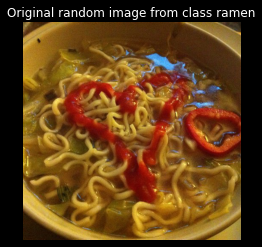

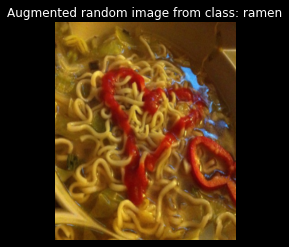

In [46]:
# View a random image and compare it to its augmented version
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import random
target_class = random.choice(train_data_1_percent.class_names)
target_dir = "10_food_classes_1_percent/train/" + target_class
random_image = random.choice(os.listdir(target_dir))
random_image_path = target_dir + "/" + random_image

# Read and plto in the random images
img = mpimg.imread(random_image_path)
plt.imshow(img)
plt.title(f"Original random image from class {target_class}")
plt.axis(False)

# Now let's plot our augmented random image
augmented_img = data_augmentation(tf.expand_dims(img , axis = 0), training=True)
plt.figure()
plt.imshow(tf.squeeze(augmented_img)/ 255.)
plt.title(f'Augmented random image from class: {target_class}')
plt.axis(False)

### Model 1: Feature extraction transfer learning on 1% of the data with data augmentation

In [51]:
# Setup the input shape and base model, freezing the base model layers 
from pyexpat import model


input_shape = (224, 224, 3)
base_model = tf.keras.applications.EfficientNetB0(include_top = False)
base_model.trainable = False

# Create input layer
inputs = layers.Input(shape = input_shape, name = "input_layer")

# Add in data augmentation Sequential model as a layer
x = data_augmentation(inputs)

# Give base_model the inputs (after augmentation) and don't train it
x = base_model(x , training = False)

# Pool output features of the base_model
x = layers.GlobalAveragePooling2D()(x)

# Put a dense layer on as the output
outputs = layers.Dense(10 , activation = "softmax" , name = "output_layer")(x)

# Make a model using the inputs and outputs
model_1  = keras.Model(inputs, outputs)

# Compile the model
model_1.compile(loss = 'categorical_crossentropy',
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ['accuracy'])

# Fit the model
history_1 = model_1.fit(train_data_1_percent,
                        epochs = 5,
                        validation_data = test_data,
                        validation_steps = int(0.25 * len(test_data)),
                        callbacks = [create_tensorboard_callback(dir_name = "transfer_learning",
                                                                experiment_name = "1_percent_data_aug")])

Saving TensorBoard log files to: transfer_learning/1_percent_data_aug/20220709-105821
Epoch 1/5
3/3 [==============================] - 132s 24s/step - loss: 2.3601 - accuracy: 0.1143 - val_loss: 2.2557 - val_accuracy: 0.1464
Epoch 2/5
3/3 [==============================] - 89s 43s/step - loss: 2.1050 - accuracy: 0.2143 - val_loss: 2.1422 - val_accuracy: 0.2303
Epoch 3/5
3/3 [==============================] - 33s 15s/step - loss: 1.9287 - accuracy: 0.3857 - val_loss: 2.0287 - val_accuracy: 0.3257
Epoch 4/5
3/3 [==============================] - 32s 15s/step - loss: 1.7882 - accuracy: 0.5143 - val_loss: 1.9389 - val_accuracy: 0.3799
Epoch 5/5
3/3 [==============================] - 28s 13s/step - loss: 1.6271 - accuracy: 0.6429 - val_loss: 1.8612 - val_accuracy: 0.4243


In [52]:
model_1.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (512, 512, 3)            0         
 al)                                                             
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling2d_4   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-traina

In [53]:
# Evaluate on the full test dataset
results_1_percent_data_aug = model_1.evaluate(test_data)
results_1_percent_data_aug

79/79 [==============================] - 108s 1s/step - loss: 1.8774 - accuracy: 0.4132


[1.8774027824401855, 0.4131999909877777]

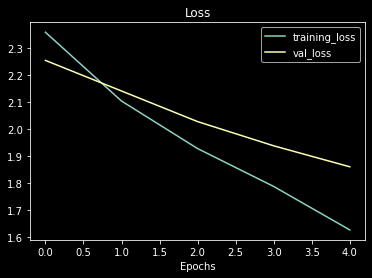

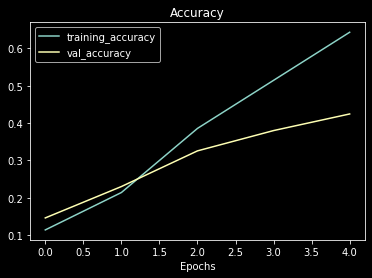

In [54]:
plot_loss_curves(history_1)

### Model 2: Feature extraction transfer learning model with 10% of data and data augmentation

In [55]:
# Get 10% of data

train_dir_10_percent = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

In [56]:
# Set data inputs 
from cProfile import label
import tensorflow as tf
IMG_SIZE = (224 , 224)

train_dir_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir_10_percent,
                                                                          label_mode = "categorical",
                                                                           image_size = IMG_SIZE)

test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode = "categorical",
                                                                image_size = IMG_SIZE)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [57]:
# How many images are in our directories 
walk_through_dir("10_food_classes_10_percent") 

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent\test'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\fried_rice'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\hamburger'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\ice_cream'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\pizza'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\ramen'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\steak'.
There are 0 directories and 250 images in '10_food_classes_10_percent

In [58]:
data_augmentation.summary()

Model: "data_augmentation"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_flip (RandomFlip)    (512, 512, 3)             0         
                                                                 
 random_rotation (RandomRota  (512, 512, 3)            0         
 tion)                                                           
                                                                 
 random_zoom (RandomZoom)    (512, 512, 3)             0         
                                                                 
 random_height (RandomHeight  (512, 512, 3)            0         
 )                                                               
                                                                 
 random_width (RandomWidth)  (512, 512, 3)             0         
                                                                 
Total params: 0
Trainable params: 0
Non-trainable

In [62]:
# Create a functional model with data augmentation
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential

# Build data augmentation layer
data_augmentation = Sequential([
  preprocessing.RandomFlip('horizontal'),
  preprocessing.RandomHeight(0.2),
  preprocessing.RandomWidth(0.2),
  preprocessing.RandomZoom(0.2),
  preprocessing.RandomRotation(0.2),
  # preprocessing.Rescaling(1./255) # keep for ResNet50V2, remove for EfficientNet                 
], name="data_augmentation")

# Setup the input shape to our model
input_shape = (224, 224, 3)

# Create a frozen base model
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Create input and output layers
inputs = layers.Input(shape=input_shape, name="input_layer") # create input layer
x = data_augmentation(inputs) # augment our training images
x = base_model(x, training=False) # pass augmented images to base model but keep it in inference mode, so batchnorm layers don't get updated: https://keras.io/guides/transfer_learning/#build-a-model 
x = layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
outputs = layers.Dense(10, activation="softmax", name="output_layer")(x)
model_2 = tf.keras.Model(inputs, outputs)

# Compile
model_2.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(lr=0.001), # use Adam optimizer with base learning rate
              metrics=["accuracy"])

c:\Users\LENOVO\anaconda3\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [63]:
model_2.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, 224, 224, 3)      0         
 al)                                                             
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-traina

### Creating a ModelCheckpoint callback
The ModelCheckpoint callback intermediately saves our model (the full model or just teh weights) during training. This is useful so we can come and start where we left off. 

In [64]:
# Set checkpoint path
checkpoint_path = "ten_percent_model_checkpoints_weights/checkpoint.ckpt"

# Create a ModelCheckpoint callback that saves the model's only
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath = checkpoint_path,
                                                         save_weights_only = True,
                                                         save_best_only = False,
                                                         save_freq = "epoch", # save every epoch
                                                         verbose = 1)


In [65]:
# Fit model 2 passing in the ModelCheckpoint callback

history_10_percent_data_aug = model_2.fit(train_data_10_percent,
                                          epochs = 5,
                                          steps_per_epoch = len(train_data_10_percent),
                                          validation_data = test_data,
                                          validation_steps = int(0.25 * len(test_data)),
                                          callbacks = [create_tensorboard_callback(dir_name = "transfer_learning",
                                                                                   experiment_name = "10_percent_data_aug"),
                                                       checkpoint_callback])

Saving TensorBoard log files to: transfer_learning/10_percent_data_aug/20220710-100523
Epoch 1/5
24/24 [==============================] - ETA: 0s - loss: 1.9296 - accuracy: 0.3893
Epoch 1: saving model to ten_percent_model_checkpoints_weights\checkpoint.ckpt
24/24 [==============================] - 134s 4s/step - loss: 1.9296 - accuracy: 0.3893 - val_loss: 1.4278 - val_accuracy: 0.6826
Epoch 2/5
24/24 [==============================] - ETA: 0s - loss: 1.3225 - accuracy: 0.6693
Epoch 2: saving model to ten_percent_model_checkpoints_weights\checkpoint.ckpt
24/24 [==============================] - 76s 3s/step - loss: 1.3225 - accuracy: 0.6693 - val_loss: 1.0518 - val_accuracy: 0.7681
Epoch 3/5
24/24 [==============================] - ETA: 0s - loss: 1.0423 - accuracy: 0.7333
Epoch 3: saving model to ten_percent_model_checkpoints_weights\checkpoint.ckpt
24/24 [==============================] - 77s 3s/step - loss: 1.0423 - accuracy: 0.7333 - val_loss: 0.8997 - val_accuracy: 0.7615
Epoch 4/5

In [66]:
model_2.evaluate(test_data)

79/79 [==============================] - 178s 2s/step - loss: 0.6945 - accuracy: 0.8140


[0.6945208311080933, 0.8140000104904175]

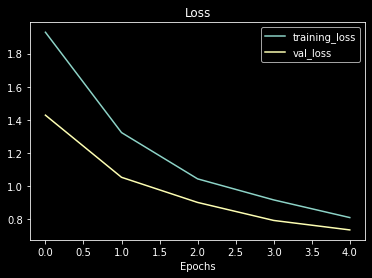

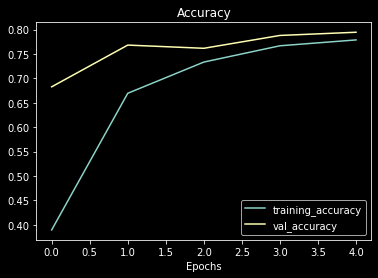

In [67]:
plot_loss_curves(history_10_percent_data_aug)

### Loading in checkpointed weights

In [68]:
# Load in saved model weights and evaluate model
model_2.load_weights(checkpoint_path)

In [69]:
# Evaluate model_2 with loaded weights
loaded_weights_model_results = model_2.evaluate(test_data)

79/79 [==============================] - 174s 2s/step - loss: 0.6945 - accuracy: 0.8140


### Model 3: Fine-Tuning an existing model on 10% of the data

> **Note:** Fine-tuning usually works best *after* training a feature extraction model for a few epochs with large amounts of custom data.

In [71]:
# Layers in a loaded model
model_2.layers

In [72]:
# Are these layers trainable?
for layer in model_2.layers:
    print(layer , layer.trainable)

<keras.engine.input_layer.InputLayer object at 0x0000021BA08D6CA0> True
<keras.engine.sequential.Sequential object at 0x0000021BB2EB9CA0> True
<keras.engine.functional.Functional object at 0x0000021BC24FC940> False
<keras.layers.pooling.GlobalAveragePooling2D object at 0x0000021BB2EB8250> True
<keras.layers.core.dense.Dense object at 0x0000021BC13AF2B0> True


In [73]:
# What layers are in our base_model (EfficientNetB2) and are they trainable?
for i , layer in enumerate(model_2.layers[2].layers):
    print(i , layer.name , layer.trainable)

0 input_8 False
1 rescaling_7 False
2 normalization_7 False
3 stem_conv_pad False
4 stem_conv False
5 stem_bn False
6 stem_activation False
7 block1a_dwconv False
8 block1a_bn False
9 block1a_activation False
10 block1a_se_squeeze False
11 block1a_se_reshape False
12 block1a_se_reduce False
13 block1a_se_expand False
14 block1a_se_excite False
15 block1a_project_conv False
16 block1a_project_bn False
17 block2a_expand_conv False
18 block2a_expand_bn False
19 block2a_expand_activation False
20 block2a_dwconv_pad False
21 block2a_dwconv False
22 block2a_bn False
23 block2a_activation False
24 block2a_se_squeeze False
25 block2a_se_reshape False
26 block2a_se_reduce False
27 block2a_se_expand False
28 block2a_se_excite False
29 block2a_project_conv False
30 block2a_project_bn False
31 block2b_expand_conv False
32 block2b_expand_bn False
33 block2b_expand_activation False
34 block2b_dwconv False
35 block2b_bn False
36 block2b_activation False
37 block2b_se_squeeze False
38 block2b_se_resha

In [74]:
# How many trainable variables are in our base model?
print(len(model_2.layers[2].trainable_variables))

0


In [76]:
# To begin fine-tuning, let's start by setting the last 10 ayers of our base_model.trainable = True
base_model.trainable = True

# Freeze all layers except for the last 10 
for layer in base_model.layers[:-10]:
    layer.trainable = False
    
# Recompile (We have to recompile our models every time we make a change)
model_2.compile(loss = "categorical_crossentropy",
                   optimizer = tf.keras.optimizers.Adam(lr = 0.0001), # When fine-tuning you typically want to lower the learning rate by 10x*
                   metrics = ['accuracy'])

c:\Users\LENOVO\anaconda3\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


> **Note:** When using fine-tuning it's best practice to lower your learning rate by some amount.
* A good rule of thumb is at least 10x (though different sources will claim other values)
* A good resource for information on this is the ULMFiT paper: <https://arxiv.org/abs/1801.06146> 

In [77]:
# Check which layers are tunable (trainable)
for layer_number , layer in enumerate(model_2.layers[2].layers):
    print(layer_number , layer.name, layer.trainable)

0 input_8 False
1 rescaling_7 False
2 normalization_7 False
3 stem_conv_pad False
4 stem_conv False
5 stem_bn False
6 stem_activation False
7 block1a_dwconv False
8 block1a_bn False
9 block1a_activation False
10 block1a_se_squeeze False
11 block1a_se_reshape False
12 block1a_se_reduce False
13 block1a_se_expand False
14 block1a_se_excite False
15 block1a_project_conv False
16 block1a_project_bn False
17 block2a_expand_conv False
18 block2a_expand_bn False
19 block2a_expand_activation False
20 block2a_dwconv_pad False
21 block2a_dwconv False
22 block2a_bn False
23 block2a_activation False
24 block2a_se_squeeze False
25 block2a_se_reshape False
26 block2a_se_reduce False
27 block2a_se_expand False
28 block2a_se_excite False
29 block2a_project_conv False
30 block2a_project_bn False
31 block2b_expand_conv False
32 block2b_expand_bn False
33 block2b_expand_activation False
34 block2b_dwconv False
35 block2b_bn False
36 block2b_activation False
37 block2b_se_squeeze False
38 block2b_se_resha

In [78]:
# Fine tune for another 5 epochs 
fine_tune_epochs = 10

# Refit the model (same as model_2 except with more trainable layers)
history_fine_10_percent_data_aug = model_2.fit(train_data_10_percent,
                                               epochs = fine_tune_epochs,
                                               validation_data = test_data,
                                               validation_steps = int(0.25*len(test_data)),
                                               initial_epoch = history_10_percent_data_aug.epoch[-1], # Start training from previous last epoch
                                               callbacks = [create_tensorboard_callback(dir_name = "transfer_learning",
                                                                                        experiment_name = "10_percent_fine_tune_last_10")])


Saving TensorBoard log files to: transfer_learning/10_percent_fine_tune_last_10/20220711-075504
Epoch 5/10
24/24 [==============================] - 145s 4s/step - loss: 0.6976 - accuracy: 0.8080 - val_loss: 0.5869 - val_accuracy: 0.8010
Epoch 6/10
24/24 [==============================] - 68s 3s/step - loss: 0.5816 - accuracy: 0.8267 - val_loss: 0.5781 - val_accuracy: 0.8026
Epoch 7/10
24/24 [==============================] - 96s 4s/step - loss: 0.5039 - accuracy: 0.8427 - val_loss: 0.5228 - val_accuracy: 0.8273
Epoch 8/10
24/24 [==============================] - 77s 3s/step - loss: 0.4678 - accuracy: 0.8573 - val_loss: 0.5474 - val_accuracy: 0.8059
Epoch 9/10
24/24 [==============================] - 63s 3s/step - loss: 0.4116 - accuracy: 0.8800 - val_loss: 0.5403 - val_accuracy: 0.8141
Epoch 10/10
24/24 [==============================] - 62s 3s/step - loss: 0.3800 - accuracy: 0.8827 - val_loss: 0.5334 - val_accuracy: 0.7993


In [80]:
results_fine_tune_10_percent = model_2.evaluate(test_data)

79/79 [==============================] - 105s 1s/step - loss: 0.4881 - accuracy: 0.8360


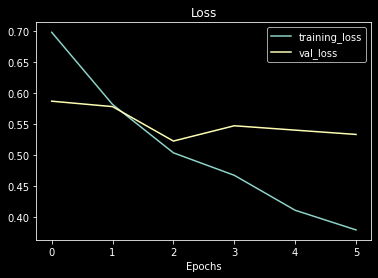

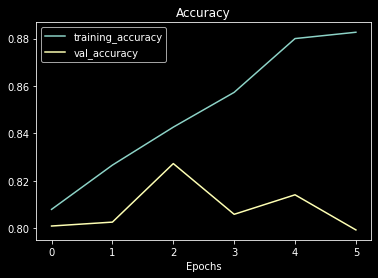

In [81]:
plot_loss_curves(history_fine_10_percent_data_aug)

The `plot_loss_curves` function works great with models only been fit once, however, we want something to compare one series of running `fit()` with another  (e.g before and after fine-tuning)

In [89]:
# Let's create a function to compare training histories
def compare_history(original_history , new_history, initial_epochs = 5):
    """
    Compare two TensorFlow History objects.
    """
    # Get original history measurements
    acc = original_history.history["accuracy"]
    loss = original_history.history['loss']
    
    val_acc = original_history.history["val_accuracy"]
    val_loss = original_history.history['val_loss']
    
    # Combine original history metrics with new_history metrics 
    total_acc = acc + new_history.history["accuracy"]
    total_loss = loss + new_history.history["loss"]
    
    total_val_acc = val_acc + new_history.history["val_accuracy"]
    total_val_loss = val_loss + new_history.history["val_loss"]
    
    # Make plots for accuracy
    plt.figure(figsize = (8 , 8))
    plt.subplot(2 , 1 , 1)
    plt.plot(total_acc , label = "Training Accuracy")
    plt.plot(total_val_acc, label = "Val Accuracy")
    plt.plot([initial_epochs-1, initial_epochs-1], plt.ylim() , label = "Start Fine Tuning")
    plt.legend(loc = "lower right")
    plt.title("Training and Validation Accuracy")
    
    # Make plots for loss
    plt.figure(figsize = (8 , 8))
    plt.subplot(2 , 1 , 2)
    plt.plot(total_loss , label = "Training Loss")
    plt.plot(total_val_loss, label = "Val Loss")
    plt.plot([initial_epochs-1, initial_epochs-1], plt.ylim() , label = "Start Fine Tuning")
    plt.legend(loc = "upper right")
    plt.title("Training and Validation Loss")

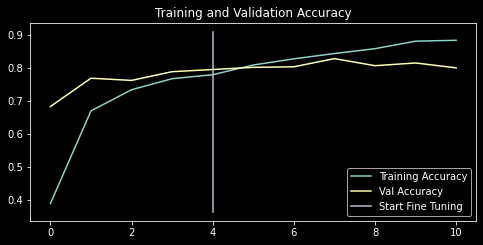

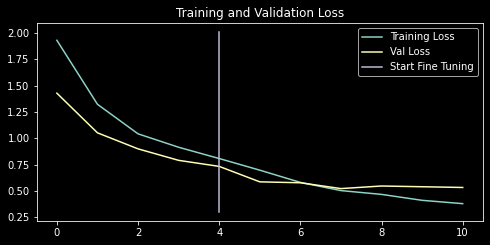

In [90]:
compare_history(history_10_percent_data_aug,
                history_fine_10_percent_data_aug,
                initial_epochs = 5)

In [92]:
wget.download(url = "https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip")
unzip_data("10_food_classes_all_data.zip")

In [94]:
# Setup data directories
train_dir_all_data = "10_food_classes_all_data/train/"
test_dir = "10_food_classes_all_data/test/"

In [93]:
# How many images are we working with now?
walk_through_dir("10_food_classes_all_data")

There are 2 directories and 0 images in '10_food_classes_all_data'.
There are 10 directories and 0 images in '10_food_classes_all_data\test'.
There are 0 directories and 250 images in '10_food_classes_all_data\test\chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_all_data\test\chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_all_data\test\fried_rice'.
There are 0 directories and 250 images in '10_food_classes_all_data\test\grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_all_data\test\hamburger'.
There are 0 directories and 250 images in '10_food_classes_all_data\test\ice_cream'.
There are 0 directories and 250 images in '10_food_classes_all_data\test\pizza'.
There are 0 directories and 250 images in '10_food_classes_all_data\test\ramen'.
There are 0 directories and 250 images in '10_food_classes_all_data\test\steak'.
There are 0 directories and 250 images in '10_food_classes_all_data\test\sushi'.
There are 

In [95]:
# Setup data inputs
import tensorflow as tf
IMG_SIZE = (224, 224)
train_data_10_classes_full = tf.keras.preprocessing.image_dataset_from_directory(train_dir_all_data,
                                                                                 label_mode = "categorical",
                                                                                 image_size = IMG_SIZE)

test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                                 label_mode = "categorical",
                                                                                 image_size = IMG_SIZE)

Found 7500 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [97]:
# Load weights from checkpoint, that way we can fine-tune from
# the same stage the 10 percent data model was fine-tuned from

model_2.load_weights(checkpoint_path)

In [98]:
checkpoint_path

'ten_percent_model_checkpoints_weights/checkpoint.ckpt'

In [99]:
model_2.evaluate(test_data)

79/79 [==============================] - 177s 2s/step - loss: 0.6945 - accuracy: 0.8140


[0.6945207715034485, 0.8140000104904175]

In [100]:
for i , layer in enumerate(model_2.layers[2].layers):
    print(i , layer.name , layer.trainable)

0 input_8 False
1 rescaling_7 False
2 normalization_7 False
3 stem_conv_pad False
4 stem_conv False
5 stem_bn False
6 stem_activation False
7 block1a_dwconv False
8 block1a_bn False
9 block1a_activation False
10 block1a_se_squeeze False
11 block1a_se_reshape False
12 block1a_se_reduce False
13 block1a_se_expand False
14 block1a_se_excite False
15 block1a_project_conv False
16 block1a_project_bn False
17 block2a_expand_conv False
18 block2a_expand_bn False
19 block2a_expand_activation False
20 block2a_dwconv_pad False
21 block2a_dwconv False
22 block2a_bn False
23 block2a_activation False
24 block2a_se_squeeze False
25 block2a_se_reshape False
26 block2a_se_reduce False
27 block2a_se_expand False
28 block2a_se_excite False
29 block2a_project_conv False
30 block2a_project_bn False
31 block2b_expand_conv False
32 block2b_expand_bn False
33 block2b_expand_activation False
34 block2b_dwconv False
35 block2b_bn False
36 block2b_activation False
37 block2b_se_squeeze False
38 block2b_se_resha

In [101]:
# Compile
model_2.compile(loss = "categorical_crossentropy",
                optimizer = tf.keras.optimizers.Adam(lr = 0.0001),
                metrics = ['accuracy'])

c:\Users\LENOVO\anaconda3\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [102]:
from gc import callbacks


fine_tune_epochs = 10

history_fine_10_classes_full = model_2.fit(train_data_10_classes_full,
                                           epochs = fine_tune_epochs,
                                           validation_data = test_data,
                                           validation_steps = int(0.25 * len(test_data)),
                                           initial_epoch = history_10_percent_data_aug.epoch[-1],
                                           callbacks = [create_tensorboard_callback(dir_name = "transfer_learning",
                                                                                    experiment_name = "full_10_classes_fine_tune_last_10")])

Saving TensorBoard log files to: transfer_learning/full_10_classes_fine_tune_last_10/20220711-145358
Epoch 5/10
235/235 [==============================] - 630s 2s/step - loss: 0.7398 - accuracy: 0.7593 - val_loss: 0.4145 - val_accuracy: 0.8635
Epoch 6/10
235/235 [==============================] - 488s 2s/step - loss: 0.5985 - accuracy: 0.8043 - val_loss: 0.3898 - val_accuracy: 0.8766
Epoch 7/10
235/235 [==============================] - 473s 2s/step - loss: 0.5355 - accuracy: 0.8223 - val_loss: 0.3796 - val_accuracy: 0.8766
Epoch 8/10
235/235 [==============================] - 416s 2s/step - loss: 0.4884 - accuracy: 0.8428 - val_loss: 0.3762 - val_accuracy: 0.8799
Epoch 9/10
235/235 [==============================] - 1136s 5s/step - loss: 0.4513 - accuracy: 0.8553 - val_loss: 0.3678 - val_accuracy: 0.8717
Epoch 10/10
235/235 [==============================] - 421s 2s/step - loss: 0.4290 - accuracy: 0.8625 - val_loss: 0.3120 - val_accuracy: 0.8947


In [103]:
results_fine_tune_full_data = model_2.evaluate(test_data)
results_fine_tune_full_data

79/79 [==============================] - 107s 1s/step - loss: 0.3105 - accuracy: 0.8960


[0.3105394244194031, 0.8960000276565552]

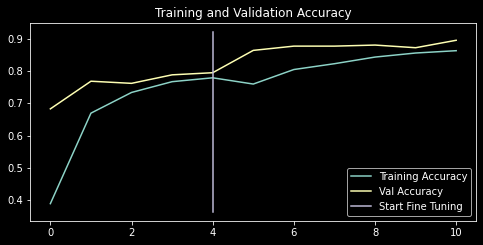

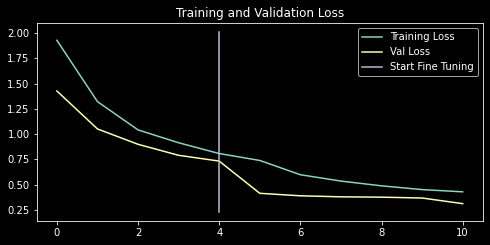

In [104]:
compare_history(original_history = history_10_percent_data_aug,
                new_history = history_fine_10_classes_full,
                initial_epochs = 5)

### Viewing our experiment data on TensorBoard

In [105]:
! tensorboard dev upload --log_dir ./transfer_learning \
    --name "Transfer Learning Experiments with 10 Food101 Classes" \
    --description  "Random" \
    --one_shot

2022-07-11 16:31:09.594927: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'cudart64_110.dll'; dlerror: cudart64_110.dll not found
2022-07-11 16:31:09.612525: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-07-11 16:33:58.454391: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'nvcuda.dll'; dlerror: nvcuda.dll not found
2022-07-11 16:33:58.475535: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-07-11 16:33:58.485191: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: DESKTOP-KB
2022-07-11 16:33:58.486863: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: DESKTOP-KB
Error: Must specify directory to upload via `--logdir`.
